<a href="https://colab.research.google.com/github/rodrigodemend/Previsao_Covid/blob/main/Notebooks/Previs%C3%A3o_das_mortes_por_Covid_19_usando_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importando todas as bibliotecas

In [ ]:
!pip install prophet

     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 49 kB 3.1 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640064 sha256=ea1de95db4d6edac570c6a4e3aa30101b19b0456ccd8599fa10fdbe27a797e0b
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

#Importando os dados limpos

In [ ]:
data_new_deaths = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Cleaned/data_new_deaths.csv', encoding='utf-8')
data_new_deaths.tail()

,date,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
660,2021-12-16,0.0,2.0,3.0,0.0,4.0,4.0,3.0,2.0,0.0,2.0,24.0,0.0,2.0,12.0,0.0,6.0,2.0,4.0,5.0,7.0,4.0,2.0,17.0,9.0,0.0,0.0,0.0
661,2021-12-17,0.0,2.0,0.0,0.0,7.0,0.0,7.0,13.0,0.0,3.0,19.0,0.0,5.0,6.0,0.0,10.0,6.0,1.0,0.0,2.0,2.0,0.0,12.0,10.0,0.0,259.0,0.0
662,2021-12-18,0.0,1.0,0.0,0.0,2.0,7.0,0.0,1.0,0.0,2.0,17.0,0.0,0.0,1.0,7.0,5.0,0.0,2.0,30.0,0.0,2.0,0.0,5.0,4.0,1.0,51.0,0.0
663,2021-12-19,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,15.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,7.0,3.0,1.0,0.0,4.0,5.0,0.0,0.0,0.0
664,2021-12-20,0.0,2.0,0.0,1.0,6.0,10.0,3.0,11.0,0.0,3.0,1.0,0.0,3.0,7.0,2.0,4.0,4.0,2.0,2.0,0.0,7.0,0.0,2.0,2.0,1.0,0.0,0.0


#Funções utilizadas no notebook

In [ ]:
def prophet_model(df, parameters=None):
  """
  Função criada para facilitar a criação do modelo com novos parâmetros e teste com cross validation
  """
  if parameters != None:
    modelo = Prophet(**parameters)
  else:
    modelo = Prophet()
  modelo.fit(df)
  df_cv = cross_validation(modelo, initial='400 days', period='30 days', horizon='30 days')
  return performance_metrics(df_cv), modelo

In [ ]:
def prophet_model_grid(df, grid):
  MAE = pd.DataFrame()
  RMSE = pd.DataFrame()
  for i in range(len(grid)):
    print('======================= '+str(i)+' ====================================')
    df_p, _ = prophet_model(df, parameters=grid[i])
    MAE[str(i)] = df_p['mae']
    RMSE[str(i)] = df_p['rmse']
  return MAE, RMSE

In [ ]:
def best_result(df, grid, parameter):
  """
  Esta função retorna o melhor resultado 
  """
  return grid[int(df.mean().sort_values().head(1).index[0])][parameter]  

In [ ]:
def print_changepoints(model):
  """
  Essa função serve para plotar os changepoints usados pelo modelo
  """
  dataframefuturo = model.make_future_dataframe(periods=30)
  dataframefuturo['cap'] = 300
  previsao = model.predict(dataframefuturo)
  fig = model.plot(previsao)
  a = add_changepoints_to_plot(fig.gca(), model, previsao)

# Visualização dos dados

In [ ]:
estado = 'SC'

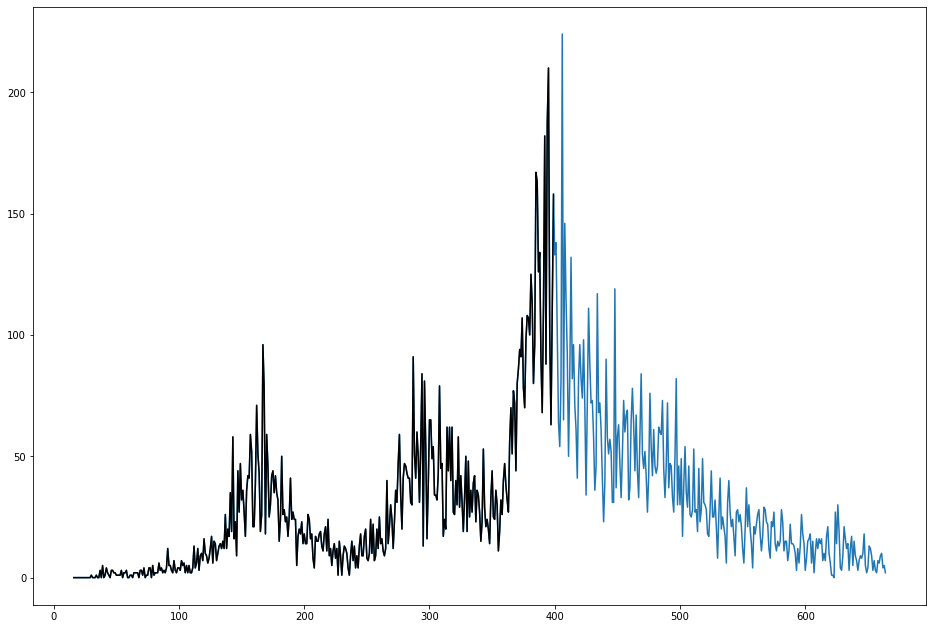

In [ ]:
data_new_deaths[estado].plot(figsize=(16,11))
data_new_deaths[estado][:400].plot(figsize=(16,11), color='black')

In [ ]:
data_new_deaths[estado].describe()

count    649.000000
mean      31.018490
std       32.198453
min        0.000000
25%        9.000000
50%       21.000000
75%       43.000000
max      224.000000
Name: SC, dtype: float64

## Modelo básico Prophet

In [ ]:
df = pd.DataFrame()
df['ds'] = data_new_deaths['date']
df['y'] = data_new_deaths[estado].values

In [ ]:
df_p, _ = prophet_model(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


In [ ]:
print("Média MAE:", df_p['mae'].mean()) 
print("Média RMSE:", df_p['rmse'].mean())

Média MAE: 21.599716541393395
Média RMSE: 28.938175969140595


# Otimizando a tendência

Criando os dataframes para salvar os resultados dos experimentos da tendência

In [ ]:
MAE_results_exp_trend = pd.DataFrame()
RMSE_results_exp_trend = pd.DataFrame()

## 1° Experimento de tendência

Fazendo uma otimização do parâmetro "changepoint_prior_scale" com os "n_changepoints" gerados automáticamente pelo prophet 

In [53]:
params_grid = {'n_changepoints':[i for i in range(5, 55, 5)],
              'changepoint_prior_scale':[i/1000 for i in range(1, 500, 20)],
               'growth':['linear', 'logistic']}
grid = ParameterGrid(params_grid)

enable = False
if enable:
  MAE, RMSE = prophet_model_grid(df, grid)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp1/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp1/RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [17]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

Salvando os resultados de MAE e RMSE

In [18]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

Achando os melhores resultados do primeiro experimento para o MAE e para o RMSE

In [54]:
grid[int(MAE.mean().sort_values().head(1).index[0])]

{'changepoint_prior_scale': 0.001, 'growth': 'logistic', 'n_changepoints': 50}

###n_changepoints

In [ ]:
best_result(df=MAE, grid=grid, parameter='n_changepoints')

50

In [ ]:
best_result(df=RMSE, grid=grid, parameter='n_changepoints')

10

De acordo com os resultados do MAE e RMSE foi escolhido o valor de n_changepoints = 50

###changepoint_prior_scale

In [ ]:
best_result(df=MAE, grid=grid, parameter='changepoint_prior_scale')

0.461

In [ ]:
best_result(df=RMSE, grid=grid, parameter='changepoint_prior_scale')

0.041

Escolhendo o valor de changepoint_prior_scale=0.461

Testando forma de crescimento linear e exponencial

In [ ]:
param = {'n_changepoints':50,
         'changepoint_prior_scale':0.461,
         'growth':'linear'}

results, _ = prophet_model(df, parameters=param)
print("MAE:", round(results['mae'].mean(), 2))
print("RMSE:", round(results['rmse'].mean(), 2))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


MAE: 18.35
RMSE: 30.37


In [ ]:
param = {'n_changepoints':50,
         'changepoint_prior_scale':0.461,
         'growth':'logistic'}

df['cap'] = 300

results, _ = prophet_model(df, parameters=param)
print("MAE:", round(results['mae'].mean(), 2))
print("RMSE:", round(results['rmse'].mean(), 2))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


MAE: 17.94
RMSE: 30.19


Visualizando os changepoints

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


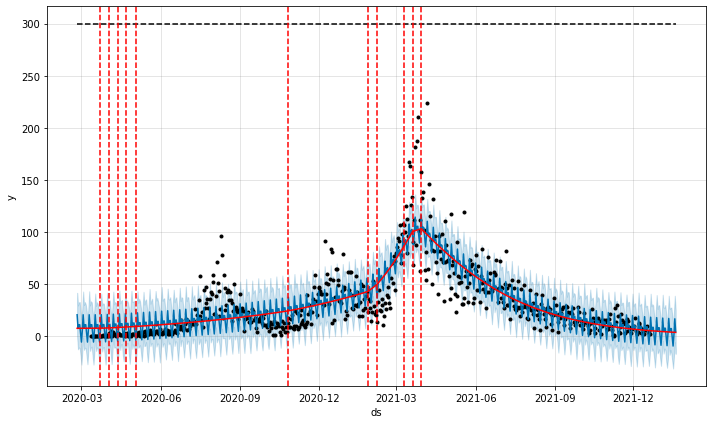

In [ ]:
param = {'n_changepoints':50,
         'changepoint_prior_scale':0.461,
         'growth':'logistic'}

results, modelo = prophet_model(df, parameters=param)
print_changepoints(modelo)

Salvando os resultados do primeiro experimento

In [ ]:
param = {'n_changepoints':50,
         'changepoint_prior_scale':0.461,
         'growth':'logistic'}

results, _ = prophet_model(df, parameters=param)
MAE_results_exp_trend['1° Exp'] = results['mae']
RMSE_results_exp_trend['1° Exp'] = results['rmse']

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


In [ ]:
print("Resultados do primeiro experimento - MAE: ", round(MAE_results_exp_trend['1° Exp'].mean(),2))
print("Resultados do primeiro experimento - RMSE: ", round(RMSE_results_exp_trend['1° Exp'].mean(),2))

Resultados do primeiro experimento - MAE:  17.94
Resultados do primeiro experimento - RMSE:  30.19


## 2° Experimento de tendência

experimento de pegar diferenças muito grandes como changepoints

In [ ]:
df_diff = df.copy()
df_diff['diff'] = df_diff['y'].diff()
dates = [i for i in df_diff.query('(diff < -50) or (diff > 50)')['ds']]
dates

['2020-08-10',
 '2020-08-12',
 '2020-12-08',
 '2020-12-16',
 '2020-12-17',
 '2021-03-16',
 '2021-03-23',
 '2021-03-24',
 '2021-03-25',
 '2021-03-27',
 '2021-04-06',
 '2021-04-07',
 '2021-04-08',
 '2021-05-04',
 '2021-05-11',
 '2021-05-18',
 '2021-05-19',
 '2021-07-07']

Rodando com as datas achadas

In [ ]:
param = {'changepoint_prior_scale' : [i/1000 for i in range(1, 500, 20)],
         'changepoints':[dates]}
grid = ParameterGrid(param)

enable = False
if enable:
  MAE, RMSE = prophet_model_grid(df, grid)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp2/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp2/RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [ ]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

Salvando os resultados de MAE e RMSE

In [ ]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

Achando os melhores resultados do segundo experimento para o MAE e para o RMSE

###changepoint_prior_scale

In [ ]:
best_result(df=MAE, grid=grid, parameter='changepoint_prior_scale')

0.401

In [ ]:
best_result(df=RMSE, grid=grid, parameter='changepoint_prior_scale')

0.401

Escolhendo o valor de changepoint_prior_scale=0.401

Testando forma de crescimento linear e exponencial

In [ ]:
param = {'changepoint_prior_scale' : 0.401,
         'changepoints':dates,
         'growth':'linear'}

results, _ = prophet_model(df, parameters=param)
print("MAE:", round(results['mae'].mean(), 2))
print("RMSE:", round(results['rmse'].mean(), 2))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


MAE: 12.22
RMSE: 15.89


In [ ]:
param = {'changepoint_prior_scale' : 0.401,
         'changepoints':dates,
         'growth':'logistic'}

df['cap'] = 300

results, _ = prophet_model(df, parameters=param)
print("MAE:", round(results['mae'].mean(), 2))
print("RMSE:", round(results['rmse'].mean(), 2))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


MAE: 13.31
RMSE: 24.72


====================================================

Visualizando os changepoints

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


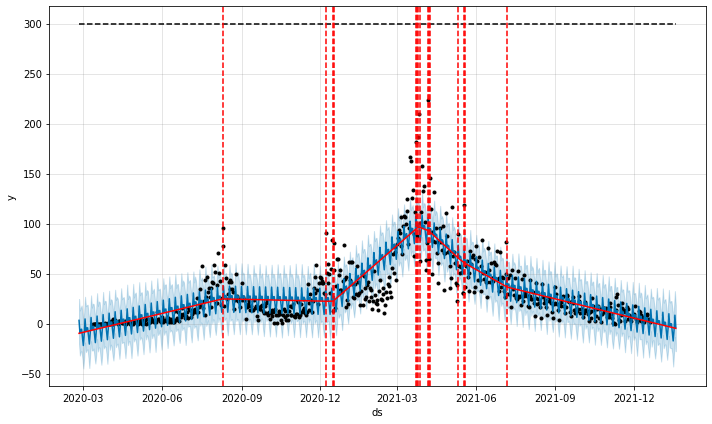

In [ ]:
param = {'changepoint_prior_scale' : 0.401,
         'changepoints':dates,
         'growth':'linear'}

results, modelo = prophet_model(df, parameters=param)
print_changepoints(modelo)

Salvando os resultados do primeiro experimento

In [ ]:
param = {'changepoint_prior_scale' : 0.401,
         'changepoints':dates,
         'growth':'linear'}

results, _ = prophet_model(df, parameters=param)
MAE_results_exp_trend['2° Exp'] = results['mae']
RMSE_results_exp_trend['2° Exp'] = results['rmse']

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


In [ ]:
print("Resultados do segundo experimento - MAE: ", round(MAE_results_exp_trend['2° Exp'].mean(),2))
print("Resultados do segundo experimento - RMSE: ", round(RMSE_results_exp_trend['2° Exp'].mean(),2))

Resultados do segundo experimento - MAE:  12.22
Resultados do segundo experimento - RMSE:  15.89


## 3° Experimento de tendência